### Importing Libraries

In [ ]:
!pip install torch torchvision pandas torchattacks tqdm  --quiet
!pip install git+https://github.com/fra31/auto-attack --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.0/142.0 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.2/144.2 kB 8.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.27.0 requires requests>=2.27.1, but you have requests 2.25.1 which is incompatible.
google-colab 1.0.0 requires requests==2.32.3, but you have requests 2.25.1 which is incompatible.
sphinx 8.1.3 requires requests>=2.30.0, but you have requests 2.25.1 which is incompatible.
tweepy 4.14.0 requires requests<3,>=2.27.0, but you have reque

In [ ]:

import os
import argparse
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from collections import OrderedDict

import torch.utils.data
import torchvision.transforms as transforms

import torch
import torchvision
import torchvision.transforms as transforms
import os
import pandas as pd
from autoattack import AutoAttack
from torchvision.utils import save_image
from torchattacks import PGDL2
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from autoattack import AutoAttack
import zipfile
import shutil
from google.colab import files
from PIL import Image





### Model

In [ ]:
class PreActBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(PreActBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)

        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False)
            )

    def forward(self, x):
        out = F.relu(self.bn1(x))
        shortcut = self.shortcut(out) if hasattr(self, 'shortcut') else x
        out = self.conv1(out)
        out = self.conv2(F.relu(self.bn2(out)))
        out += shortcut
        return out


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def PreActResNet18():
    return ResNet(PreActBlock, [2,2,2,2])

def ResNet18():
    return ResNet(BasicBlock, [2,2,2,2])

def ResNet34():
    return ResNet(BasicBlock, [3,4,6,3])

def ResNet50():
    return ResNet(Bottleneck, [3,4,6,3])

def ResNet101():
    return ResNet(Bottleneck, [3,4,23,3])

def ResNet152():
    return ResNet(Bottleneck, [3,8,36,3])


### Additional Functions

In [ ]:
def get_train_loader(dataset, valid_size=1024, batch_size=32):
    '''Split dataset into [train:valid] and return a DataLoader for the training part.'''

    indices = list(range(len(dataset)))
    train_sampler = torch.utils.data.SubsetRandomSampler(indices[valid_size:])
    train = torch.utils.data.DataLoader(dataset, sampler=train_sampler, batch_size=batch_size)

    return train

def get_validation_loader(dataset, valid_size=1024, batch_size=32):
    '''Split dataset into [train:valid] and return a DataLoader for the validation part.'''

    indices = list(range(len(dataset)))
    valid_sampler = torch.utils.data.SubsetRandomSampler(indices[:valid_size])
    valid = torch.utils.data.DataLoader(dataset, sampler=valid_sampler, batch_size=batch_size)

    return valid

def load_data(batch_size=1):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return test_loader

# Load the model (for example, ResNet18 pretrained on CIFAR-10)
def load_model(model_path, num_classes=10):
    model = torchvision.models.resnet18(pretrained=False)
    model.fc = torch.nn.Linear(model.fc.in_features, num_classes)  # Adjust for num classes
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    return model

### Generating Adversarial Dataset

In [ ]:
def attack_PGD_flexible(model, x, y, eps=0.03, stepsize=20, iterations=20, p="inf", targeted=False):
    """
    Implements a flexible PGD attack with support for various norms and targeted/untargeted attacks.

    Args:
    - model: The neural network to attack.
    - x: Input images (original images).
    - y: True labels (untargeted) or target labels (targeted).
    - eps: Radius of the norm-ball for perturbation.
    - stepsize: Step size for gradient update.
    - iterations: Number of PGD steps.
    - p: Norm type ('inf' for l_inf, or any positive integer for l_p norms).
    - targeted: If True, performs a targeted attack; otherwise, untargeted.

    Returns:
    - adv_examples: Adversarial examples (perturbed inputs).
    """
    model.eval()  # Ensure the model is in evaluation mode.
    x.requires_grad = True

    # Initialize perturbations randomly within the norm-ball
    if p == "inf":
        delta = (torch.rand_like(x) * 2 - 1) * eps  # Uniformly distributed in [-eps, eps]
    else:
        delta = torch.randn_like(x)  # Random direction
        norms = torch.norm(delta.view(delta.size(0), -1), dim=1, p=p)
        norms[norms == 0] = 1  # Avoid division by zero
        delta /= norms.view(-1, 1, 1, 1)  # Project onto p-norm ball
        delta *= torch.rand(delta.size(0), 1, 1, 1, device=x.device) * eps

    delta = delta.to(x.device)

    # PGD iterations
    for i in range(iterations):
        adv_examples = x + delta
        adv_examples.requires_grad_(True)

        # Forward pass
        outputs = model(torch.clamp(adv_examples, 0, 1))

        # Compute loss
        loss = F.cross_entropy(outputs, y)
        if targeted:
            loss = -loss  # Minimize loss for targeted attack

        if adv_examples.grad is None:
            adv_examples.retain_grad()  # Allow gradient computation

        # Backward pass
        model.zero_grad()
        loss.backward()

        # Compute gradient step
        if p == "inf":
            gradient = stepsize * adv_examples.grad.sign()
        else:
            gradient = adv_examples.grad
            norms = torch.norm(gradient.view(gradient.size(0), -1), dim=1, p=p)
            norms[norms == 0] = 1  # Avoid division by zero
            gradient /= norms.view(-1, 1, 1, 1)  # Normalize gradient
            gradient *= stepsize

        # Update adversarial examples
        if not targeted:
            delta = delta + gradient
        else:
            delta = delta - gradient

        # Project perturbations back to the norm-ball
        if p == "inf":
            delta = torch.clamp(delta, -eps, eps)
        else:
            norms = torch.norm(delta.view(delta.size(0), -1), dim=1, p=p)
            norms[norms == 0] = 1  # Avoid division by zero
            mask = norms > eps
            delta[mask] /= norms[mask].view(-1, 1, 1, 1)  # Normalize to p-norm ball
            delta[mask] *= eps

    # Create final adversarial examples
    adv_examples = torch.clamp(x + delta, 0, 1)

    return adv_examples

def generate_and_log_adv_examples_pgd(model, dataloader, epsilon=0.03, steps=40, alpha=0.01,max_images=1000):


    results = []
    for idx, (inputs, targets) in enumerate(dataloader):
        if idx >= max_images:
            print("Reached the limit of 1,000 images.")
            break
        inputs, targets = inputs.to(device), targets.to(device)

        # Original accuracy
        #original_accuracy = calculate_accuracy(model, inputs, targets)

        # Save original image
        orig_save_path = os.path.join(ADV_IMAGE_DIR, f"img_{idx}_original.png")
        save_image(inputs[0], orig_save_path)
        print(f"Saved original image at {orig_save_path}")
        label_save_path = os.path.join(ADV_IMAGE_DIR, f"img_{idx}_label.txt")
        with open(label_save_path, "w") as f:
            f.write(str(targets[0].item()))
        print(f"Saved original image and label at {orig_save_path}, {label_save_path}")

        # L_inf attack
        adv_inputs_linf = attack_PGD_flexible(model, inputs, targets, eps=epsilon, stepsize=40, iterations=40, p="inf", targeted=False)
        linf_save_path = os.path.join(ADV_IMAGE_DIR, f"img_{idx}_atk_Linf.png")
        save_image(adv_inputs_linf[0], linf_save_path)
        #linf_accuracy = calculate_accuracy(model, adv_inputs_linf, targets)
        print(f"Saved L_inf adversarial image at {linf_save_path}")

        # PGD L2 attack
        adv_inputs_l2 = attack_PGD_flexible(model, inputs, targets, eps=0.3, stepsize=20, iterations=20, p=2, targeted=False)
        l2_save_path = os.path.join(ADV_IMAGE_DIR, f"img_{idx}_atk_PGD_L2.png")
        save_image(adv_inputs_l2[0], l2_save_path)
        #l2_accuracy = calculate_accuracy(model, adv_inputs_l2, targets)
        print(f"Saved PGD L2 adversarial image at {l2_save_path}")

        # Log results
        results.append({
            "Index": idx,
            "Original Image": orig_save_path,
            "L_inf Adv Image": linf_save_path,
            "PGD_L2 Adv Image": l2_save_path,
            "Target":targets[0].item()
        })

    # Save results to CSV
    results_df = pd.DataFrame(results)
    results_df.to_csv(RESULTS_FILE, index=False)
    print(f"Results saved to {RESULTS_FILE}")

def generate_and_log_adv_examples(model, dataloader, epsilon=0.03, steps=40, alpha=0.01,max_images=1000):
    # Create AutoAttack for L_inf
    adversary_linf = AutoAttack(model, norm='Linf', eps=epsilon)
    adversary_linf.attacks_to_run = ['apgd-ce']  # Specify attack type for L_inf

    # Create PGD L2 attack
    adversary_l2 = PGDL2(model, eps=epsilon, alpha=alpha, steps=steps)

    results = []
    for idx, (inputs, targets) in enumerate(dataloader):
        if idx >= max_images:
            print("Reached the limit of 1,000 images.")
            break
        inputs, targets = inputs.to(device), targets.to(device)

        # Original accuracy
        #original_accuracy = calculate_accuracy(model, inputs, targets)

        # Save original image
        orig_save_path = os.path.join(ADV_IMAGE_DIR, f"img_{idx}_original.png")
        save_image(inputs[0], orig_save_path)
        print(f"Saved original image at {orig_save_path}")
        label_save_path = os.path.join(ADV_IMAGE_DIR, f"img_{idx}_label.txt")
        with open(label_save_path, "w") as f:
            f.write(str(targets[0].item()))
        print(f"Saved original image and label at {orig_save_path}, {label_save_path}")

        # L_inf attack
        adv_inputs_linf = adversary_linf.run_standard_evaluation(inputs, targets, bs=1)
        linf_save_path = os.path.join(ADV_IMAGE_DIR, f"img_{idx}_atk_Linf.png")
        save_image(adv_inputs_linf[0], linf_save_path)
        #linf_accuracy = calculate_accuracy(model, adv_inputs_linf, targets)
        print(f"Saved L_inf adversarial image at {linf_save_path}")

        # PGD L2 attack
        adv_inputs_l2 = adversary_l2(inputs, targets)
        l2_save_path = os.path.join(ADV_IMAGE_DIR, f"img_{idx}_atk_PGD_L2.png")
        save_image(adv_inputs_l2[0], l2_save_path)
        #l2_accuracy = calculate_accuracy(model, adv_inputs_l2, targets)
        print(f"Saved PGD L2 adversarial image at {l2_save_path}")

        # Log results
        results.append({
            "Index": idx,
            "Original Image": orig_save_path,
            "L_inf Adv Image": linf_save_path,
            "PGD_L2 Adv Image": l2_save_path,
            "Target":targets[0].item()
        })

    # Save results to CSV
    results_df = pd.DataFrame(results)
    results_df.to_csv(RESULTS_FILE, index=False)
    print(f"Results saved to {RESULTS_FILE}")

In [ ]:


# Set device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Directories to save adversarial images
ADV_IMAGE_DIR = "/content/adv_images"
RESULTS_FILE = "/content/results.csv"
os.makedirs(ADV_IMAGE_DIR, exist_ok=True)
# Define data transformations and loaders
train_transform = transforms.Compose([transforms.ToTensor()])
cifar = torchvision.datasets.CIFAR10('./data/', download=True, transform=train_transform)

def main():

    model = ResNet18().to(device)
    test_loader = get_validation_loader(cifar)
    generate_and_log_adv_examples_pgd(model, test_loader, epsilon=0.03, steps=40, alpha=0.01,max_images=1000)

if __name__ == "__main__":
    main()


def zip_adv_images(zip_name="adv_images2.zip"):

    with zipfile.ZipFile(zip_name, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, files in os.walk(ADV_IMAGE_DIR):
            for file in files:
                zipf.write(os.path.join(root, file), os.path.relpath(os.path.join(root, file), ADV_IMAGE_DIR))

    print(f"Created zip file: {zip_name}")
    return zip_name

def download_zip(zip_name):

    zip_file_path = zip_adv_images(zip_name)
    files.download(zip_file_path)
    print("Download started...")

download_zip("adv_images1.zip")


Files already downloaded and verified
Saved original image at /content/adv_images2/img_0_original.png
Saved original image and label at /content/adv_images2/img_0_original.png, /content/adv_images2/img_0_label.txt


<ipython-input-110-11a0eea1f8ea>:46: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:489.)
  if adv_examples.grad is None:


Saved L_inf adversarial image at /content/adv_images2/img_0_atk_Linf.png
Saved PGD L2 adversarial image at /content/adv_images2/img_0_atk_PGD_L2.png
Saved original image at /content/adv_images2/img_1_original.png
Saved original image and label at /content/adv_images2/img_1_original.png, /content/adv_images2/img_1_label.txt
Saved L_inf adversarial image at /content/adv_images2/img_1_atk_Linf.png
Saved PGD L2 adversarial image at /content/adv_images2/img_1_atk_PGD_L2.png
Saved original image at /content/adv_images2/img_2_original.png
Saved original image and label at /content/adv_images2/img_2_original.png, /content/adv_images2/img_2_label.txt
Saved L_inf adversarial image at /content/adv_images2/img_2_atk_Linf.png
Saved PGD L2 adversarial image at /content/adv_images2/img_2_atk_PGD_L2.png
Saved original image at /content/adv_images2/img_3_original.png
Saved original image and label at /content/adv_images2/img_3_original.png, /content/adv_images2/img_3_label.txt
Saved L_inf adversarial i

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download started...


In [ ]:

# Set device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Directories to save adversarial images
ADV_IMAGE_DIR = "/content/adv_images"
RESULTS_FILE = "/content/results.csv"
os.makedirs(ADV_IMAGE_DIR, exist_ok=True)
# Define data transformations and loaders
train_transform = transforms.Compose([transforms.ToTensor()])
cifar = torchvision.datasets.CIFAR10('./data/', download=True, transform=train_transform)

Files already downloaded and verified


In [ ]:
def main():

    model = ResNet18().to(device)
    checkpoint = torch.load('models/pgd_adversarial_training.pth', map_location=torch.device('cpu'))
    new_state_dict = OrderedDict()
    for key in checkpoint['net'].keys() :
        new_state_dict[key[7:]] = checkpoint['net'][key]
    model.load_state_dict(new_state_dict)
    model = model.to(device)

    test_loader = get_validation_loader(cifar)#load_data(batch_size=64)
    generate_and_log_adv_examples(model, test_loader, epsilon=0.03, steps=40, alpha=0.02,max_images=2000)

if __name__ == "__main__":
    main()


def zip_adv_images(zip_name="adv_images.zip"):

    with zipfile.ZipFile(zip_name, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, files in os.walk(ADV_IMAGE_DIR):
            for file in files:
                zipf.write(os.path.join(root, file), os.path.relpath(os.path.join(root, file), ADV_IMAGE_DIR))

    print(f"Created zip file: {zip_name}")
    return zip_name

def download_zip(zip_name):

    zip_file_path = zip_adv_images(zip_name)
    files.download(zip_file_path)
    print("Download started...")

download_zip("adv_images.zip")


<ipython-input-83-0c8a014ce750>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('models/pgd_adversarial_training.pth', map_location=torch.device('cp

setting parameters for standard version
Saved original image at /content/adv_images/img_0_original.png
Saved original image and label at /content/adv_images/img_0_original.png, /content/adv_images/img_0_label.txt
using standard version including apgd-ce.
initial accuracy: 6.25%
apgd-ce - 1/2 - 1 out of 1 successfully perturbed
apgd-ce - 2/2 - 0 out of 1 successfully perturbed
robust accuracy after APGD-CE: 3.12% (total time 1.5 s)
max Linf perturbation: 0.03000, nan in tensor: 0, max: 1.00000, min: 0.00000
robust accuracy: 3.12%
Saved L_inf adversarial image at /content/adv_images/img_0_atk_Linf.png
Saved PGD L2 adversarial image at /content/adv_images/img_0_atk_PGD_L2.png
Saved original image at /content/adv_images/img_1_original.png
Saved original image and label at /content/adv_images/img_1_original.png, /content/adv_images/img_1_label.txt
using standard version including apgd-ce.
initial accuracy: 18.75%
apgd-ce - 1/6 - 0 out of 1 successfully perturbed
apgd-ce - 2/6 - 1 out of 1 s

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download started...


### MixedNuts Functions

In [ ]:
def layer_normalization(logits):
    """Apply layer normalization to logits."""
    mean = logits.mean(dim=1, keepdim=True)
    std = logits.std(dim=1, keepdim=True)
    return (logits - mean) / (std + 1e-5)

def nonlinear_transform(logits, s, p, c, clamp_fn=F.gelu):
    """
    Nonlinear logit transformation: h_M(s, p, c)
    Parameters:
        logits: Raw logits
        s: Scaling factor
        p: Power exponent
        c: Bias
        clamp_fn: Clamping function (default GELU)
    Returns:
        Transformed logits
    """
    logits = layer_normalization(logits)
    logits = clamp_fn(logits + c)
    logits = s * torch.pow(torch.abs(logits), p) * torch.sign(logits)
    return logits

def mix_logits(accurate_logits, robust_logits, alpha):
    """
    Mix logits from accurate and robust models.
    Parameters:
        accurate_logits: Logits from the accurate model
        robust_logits: Transformed logits from the robust model
        alpha: Mixing weight
    Returns:
        Mixed logits
    """
    accurate_probs = F.softmax(accurate_logits, dim=1)
    robust_probs = F.softmax(robust_logits, dim=1)
    mixed_probs = (1 - alpha) * accurate_probs + alpha * robust_probs
    return torch.log(mixed_probs)

def calculate_margin(logits):
    """
    Calculate margin for each sample.
    Margin = confidence(predicted class) - confidence(highest incorrect class)
    """
    probs = F.softmax(logits, dim=-1)  # Convert logits to probabilities
    top2_probs, indices = torch.topk(probs, 2, dim=-1)  # Get top 2 probabilities
    margin = top2_probs[:, 0] - top2_probs[:, 1]  # Difference between top probabilities
    return margin.cpu().numpy()





### Margin Analysis

In [ ]:
class AdvImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        """
        Args:
            image_dir (str): Directory with all the adversarial images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.image_dir = image_dir
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith(f'_atk_PGD_L2.png')]
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.image_files[idx])
        label_name = img_name.replace("_atk_PGD_L2.png", "_label.txt")
        image = Image.open(img_name).convert("RGB")

        with open(label_name, "r") as f:
            label = int(f.read().strip())

        if self.transform:
            image = self.transform(image)

        return image, label


def load_adv_images(adv_image_dir, batch_size=32):
    """
    Load adversarial images saved in 'adv_image_dir' folder.
    Args:
        adv_image_dir: The directory containing adversarial images.
        batch_size: The batch size for DataLoader.
    """
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])

    adv_dataset = AdvImageDataset(image_dir=adv_image_dir, transform=transform)
    adv_loader = DataLoader(adv_dataset, batch_size=batch_size, shuffle=False)

    return adv_loader


def margin_distribution_analysis(accurate_model, robust_model, data_loader, device):
    margins = {
        "Accurate Model (Correct)": [],
        "Accurate Model (Incorrect)": [],
        "Robust Model (Correct)": [],
        "Robust Model (Incorrect)": [],
        "Robust Model (Layer Norm) (Correct)": [],
        "Robust Model (Layer Norm) (Incorrect)": [],
        "Robust Model (Transformed with Layer Norm) (Correct)": [],
        "Robust Model (Transformed with Layer Norm) (Incorrect)": []
    }
    accurate_model = accurate_model.to(device)
    robust_model = robust_model.to(device)

    accurate_model.eval()
    robust_model.eval()

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            accurate_logits = accurate_model(inputs)
            accurate_predictions = torch.argmax(accurate_logits, dim=1)
            correct_accurate = (accurate_predictions == targets)

            # Ensure margins are correctly moved to CPU before appending
            margins["Accurate Model (Correct)"].extend(calculate_margin(accurate_logits.cpu())[correct_accurate.cpu()])
            margins["Accurate Model (Incorrect)"].extend(calculate_margin(accurate_logits.cpu())[~correct_accurate.cpu()])

            # Robust model margins
            robust_logits = robust_model(inputs)
            robust_predictions = torch.argmax(robust_logits, dim=1)
            correct_robust = (robust_predictions == targets)

            margins["Robust Model (Correct)"].extend(calculate_margin(robust_logits.cpu())[correct_robust.cpu()])
            margins["Robust Model (Incorrect)"].extend(calculate_margin(robust_logits.cpu())[~correct_robust.cpu()])

            # Robust model with layer norm
            robust_ln_logits = layer_normalization(robust_logits)
            margins["Robust Model (Layer Norm) (Correct)"].extend(calculate_margin(robust_ln_logits.cpu())[correct_robust.cpu()])
            margins["Robust Model (Layer Norm) (Incorrect)"].extend(calculate_margin(robust_ln_logits.cpu())[~correct_robust.cpu()])

            # Robust model with transformation and layer norm
            transformed_logits = nonlinear_transform(robust_logits, 0.02, 8, 0.1)
            transformed_ln_logits = layer_normalization(transformed_logits)
            margins["Robust Model (Transformed with Layer Norm) (Correct)"].extend(calculate_margin(transformed_ln_logits.cpu())[correct_robust.cpu()])
            margins["Robust Model (Transformed with Layer Norm) (Incorrect)"].extend(calculate_margin(transformed_ln_logits.cpu())[~correct_robust.cpu()])

    return margins

def plot_margin_distributions_together(margins, title_prefix):
    """
    Plot the margin distributions together (correct and incorrect) for each model type.
    Args:
        margins: Dictionary containing margin lists for different models.
        title_prefix: Prefix for the title to distinguish between clean and adversarial data.
    """
    # Extract the models we need to plot (e.g., 'Accurate Model')
    model_names = ["Accurate Model", "Robust Model", "Robust Model (Layer Norm)", "Robust Model (Transformed with Layer Norm)"]
    fig, axes = plt.subplots(len(model_names), 1, figsize=(4.5, 4.5 * len(model_names)))

    if len(model_names) == 1:
        axes = [axes]  # Handle the case when there is only one plot

    for i, model_name in enumerate(model_names):
        # Combine "Correct" and "Incorrect" keys for the current model
        correct_key = f"{model_name} (Correct)"
        incorrect_key = f"{model_name} (Incorrect)"

        correct_margins = margins.get(correct_key, [])
        incorrect_margins = margins.get(incorrect_key, [])

        # Plotting both correct and incorrect margins on the same plot
        axes[i].hist(correct_margins, bins=50, alpha=0.6, density=True, label='Correct', color='blue')
        axes[i].hist(incorrect_margins, bins=50, alpha=0.6, density=True, label='Incorrect', color='red')

        axes[i].set_title(f"{title_prefix}: {model_name}")
        axes[i].set_xlabel("Margin")
        axes[i].set_ylabel("Density")
        axes[i].legend(loc='upper right')
        axes[i].grid(True)

    plt.tight_layout()
    plt.show()


In [ ]:


valid_size = 1024
batch_size = 32
accurate_model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet20", pretrained=True).to(device)
robust_model = ResNet18().to(device)
checkpoint = torch.load('models/pgd_adversarial_training.pth', map_location=torch.device('cpu'))
new_state_dict = OrderedDict()
for key in checkpoint['net'].keys() :
    new_state_dict[key[7:]] = checkpoint['net'][key]
robust_model.load_state_dict(new_state_dict)

accurate_model = accurate_model.to(device)
robust_model = robust_model.to(device)

clean_loader = get_validation_loader(cifar, batch_size=32)
adv_loader = load_adv_images('./adv_images', batch_size=32)


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
<ipython-input-240-fe93d42228b8>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoin

In [ ]:
clean_margins = margin_distribution_analysis(accurate_model, robust_model, clean_loader, device)

In [ ]:
adv_margins = margin_distribution_analysis(accurate_model, robust_model, adv_loader, device)

Plotting for Clean Data...


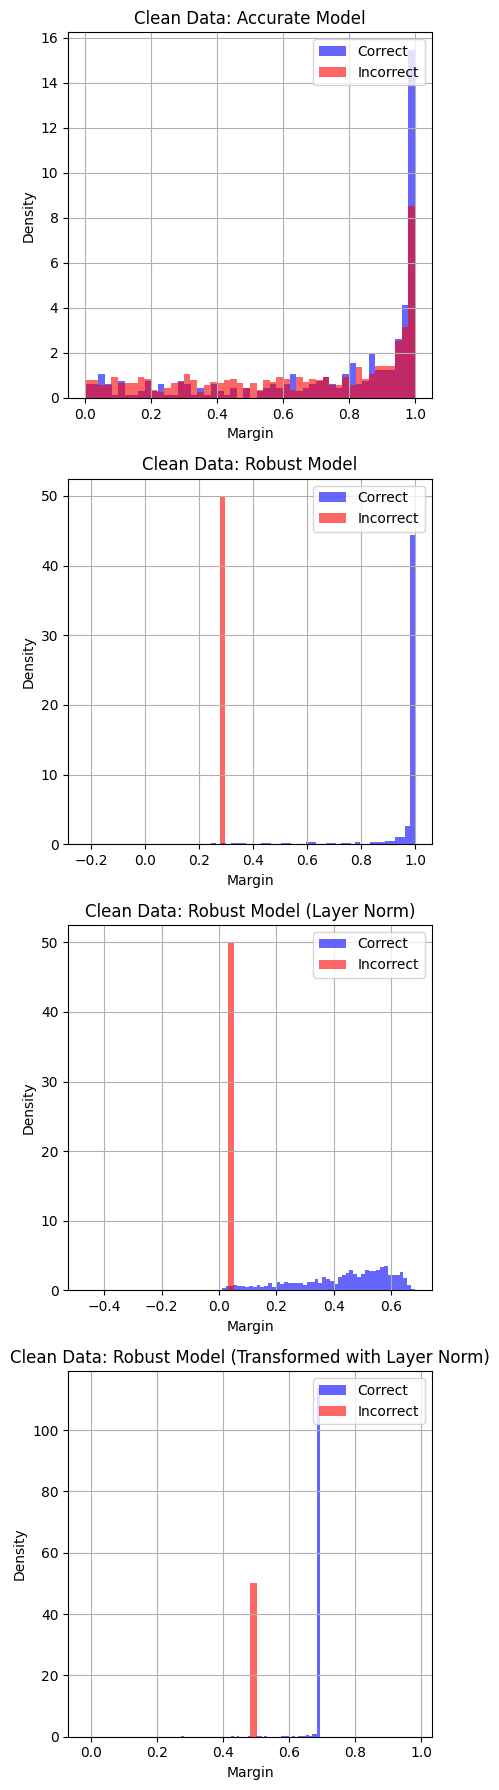

Plotting for Adversarial Data...


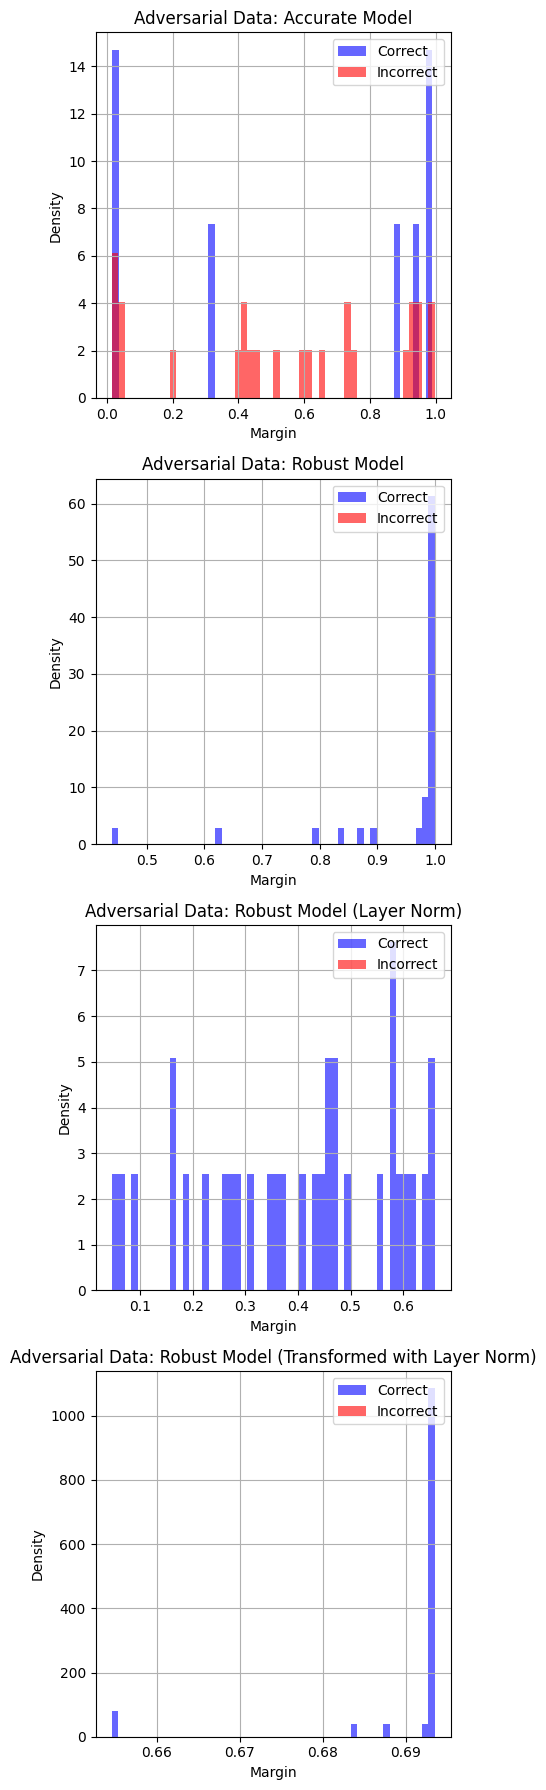

In [ ]:
print("Plotting for Clean Data...")
plot_margin_distributions_together(clean_margins, title_prefix="Clean Data")

print("Plotting for Adversarial Data...")
plot_margin_distributions_together(adv_margins, title_prefix="Adversarial Data")

### **Effect of Non-Linear Transformation**

In [ ]:
def calculate_margin(logits):
    probs = F.softmax(logits, dim=1)
    top2 = torch.topk(probs, 2, dim=1).values
    return top2[:, 0] - top2[:, 1]  # Difference between highest and second-highest probabilities

def analyze_margins_with_probabilities(
    accurate_model, robust_model, data_loader, device,
    margin_threshold_small=0.1, margin_threshold_large=0.8
):
    accurate_model = accurate_model.to(device).eval()
    robust_model = robust_model.to(device).eval()

    results = {"small_margin": [], "large_margin": []}

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Accurate model
            accurate_logits = accurate_model(inputs)
            accurate_probs = F.softmax(accurate_logits, dim=1)

            # Robust model
            robust_logits = robust_model(inputs)
            robust_probs = F.softmax(robust_logits, dim=1)


            # Transformed robust logits
            transformed_logits = nonlinear_transform(robust_logits, 0.1, 5.5, 0.1)
            transformed_probs = F.softmax(transformed_logits, dim=1)

            # Margins
            accurate_margins = calculate_margin(accurate_logits)
            robust_margins = calculate_margin(robust_logits)

            # Filter by margin size
            for i in range(len(targets)):
                margin = robust_margins[i].item()
                #transformed_predicted_class == torch.argmax(transformed_probs[i]).item()
                entry = {
                    "raw_logits": robust_logits[i].cpu(),
                    "raw_probs": robust_probs[i].cpu(),
                    "transformed_probs": transformed_probs[i].cpu(),
                    "margin": margin,
                    "label": targets[i].item()
                    # "prediction": transformed_predicted_class
                }
                #if entry["label"] != transformed_predicted_class:
                if margin <= margin_threshold_small:
                    results["small_margin"].append(entry)
                elif margin >= margin_threshold_large:
                    results["large_margin"].append(entry)

    return results

def plot_margin_analysis(case_data, title, case_color):
    logits = case_data["raw_logits"]
    raw_probs = case_data["raw_probs"]
    transformed_probs = case_data["transformed_probs"]
    margin_raw = case_data["margin_raw"]
    margin_transformed = case_data["margin_transformed"]

    classes = range(len(logits))

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    fig.suptitle(title, fontsize=14)

    # Raw logits
    axes[0].bar(classes, logits, color=case_color, alpha=0.7)
    axes[0].set_title("Raw Logits")
    axes[0].set_xlabel("Class")
    axes[0].set_ylabel("Logit Value")

    # Raw probabilities
    axes[1].bar(classes, raw_probs, color=case_color, alpha=0.7)
    axes[1].set_title("Raw Probabilities")
    axes[1].set_xlabel("Class")
    axes[1].annotate(f"Margin: {margin_raw:.3f}", xy=(0.5, max(raw_probs) * 0.8), fontsize=10)

    # Transformed probabilities
    axes[2].bar(classes, transformed_probs, color=case_color, alpha=0.7)
    axes[2].set_title("Transformed Probabilities")
    axes[2].set_xlabel("Class")
    axes[2].annotate(f"Margin: {margin_transformed:.3f} ", xy=(0.5, max(transformed_probs) * 0.8), fontsize=10)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

def calculate_probabilities_and_plot(results):
    # Example of margin filtering and plotting
    for case in ["small_margin", "large_margin"]:
        case_data = results[case][0]  # Pick the first example in each margin case

        logits = case_data["raw_logits"]
        raw_probs = case_data["raw_probs"]
        transformed_probs = case_data["transformed_probs"]

        # Compute margins
        margin_raw = raw_probs.max() - torch.topk(raw_probs, 2)[0][-1]
        margin_transformed = transformed_probs.max() - torch.topk(transformed_probs, 2)[0][-1]

        # Format case data for plotting
        case_plot_data = {
            "raw_logits": logits.numpy(),
            "raw_probs": raw_probs.numpy(),
            "transformed_probs": transformed_probs.numpy(),
            "margin_raw": margin_raw.item(),
            "margin_transformed": margin_transformed.item(),
        }

        # Plot for small and large margin cases
        plot_margin_analysis(case_plot_data, title=f"Case: {case.capitalize()}", case_color="blue" if case == "large_margin" else "orange")



In [ ]:
results=analyze_margins_with_probabilities(
    accurate_model, robust_model, clean_loader, device,
    margin_threshold_small=0.1, margin_threshold_large=0.7
)


In [ ]:
print(results['small_margin'])

[{'raw_logits': tensor([-2.0431, -2.5449,  5.7949,  4.2633,  5.5867,  0.5563,  4.6387, -6.6984,
        -4.3242, -5.2288]), 'raw_probs': tensor([1.6793e-04, 1.0167e-04, 4.2571e-01, 9.2043e-02, 3.4573e-01, 2.2597e-03,
        1.3396e-01, 1.5972e-06, 1.7158e-05, 6.9440e-06]), 'transformed_probs': tensor([0.0942, 0.0942, 0.1216, 0.0977, 0.1153, 0.0942, 0.1002, 0.0942, 0.0942,
        0.0942]), 'margin': 0.07998701930046082, 'label': 2}]


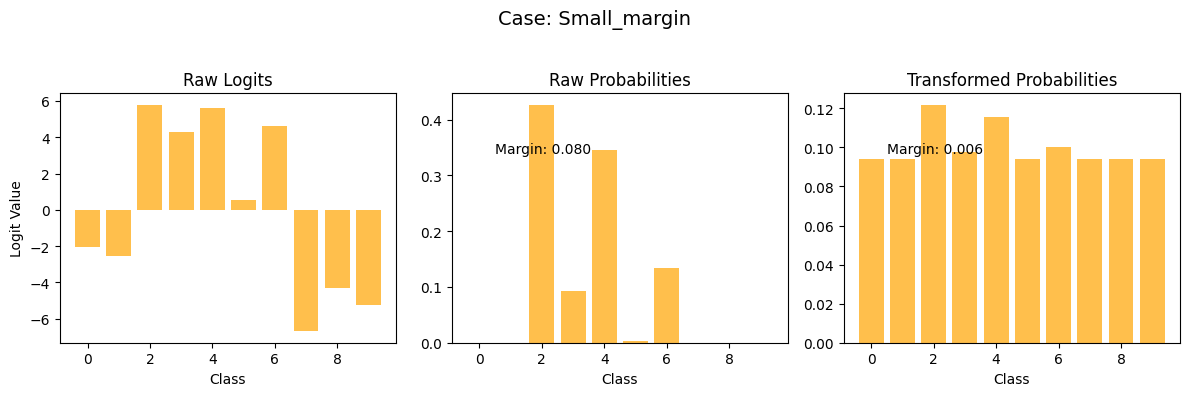

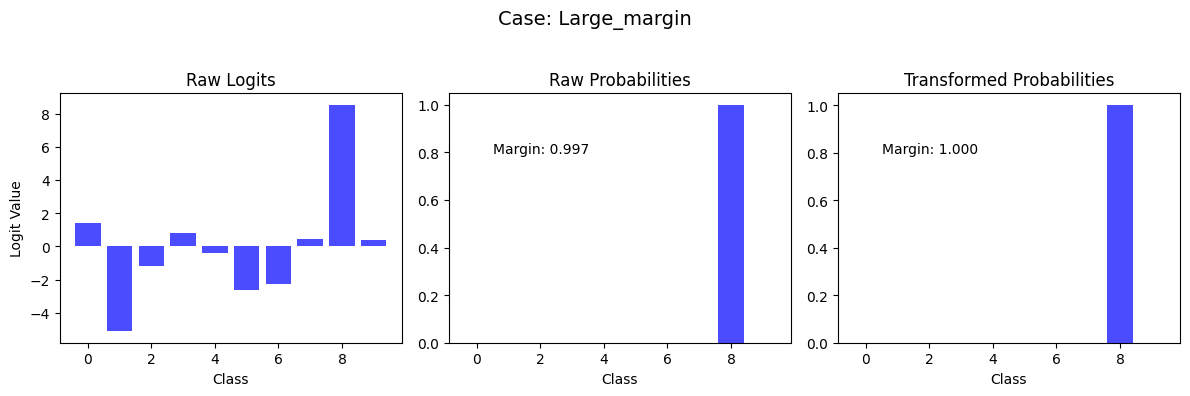

In [ ]:
calculate_probabilities_and_plot(results)